In [7]:
import numpy as np
import matplotlib.pyplot as plt

from meta_training import (
    EvaluationConfig,
    MetaTrainingConfig,
    resolve_device,
    run_meta_training,
)
from evaluate_functions import (
    average_accuracy_across_sequences,
    average_correct_retrievals_across_sequences,
    compute_recall_accuracies,
)
from synthetic_datasets import InContextRecallDataset


In [8]:
training_config = MetaTrainingConfig(
    device_preference="cuda",
    key_dim=16,
    val_dim=16,
    context_dim=5,
    seq_len=50,
    num_sequences=500,
    batch_size=10,
    recall_window=1,
    output_corr=0.5,
    inner_optimizer_kwargs={"beta1": 0.95, "beta2": 0.99, "epsilon": 1e-8},
    outer_optimizer_kwargs={"lr": 0.01},
    log_every_sequences=50,
)

actual_device = resolve_device(training_config.device_preference)
print(f"--- Starting Training on {actual_device} ---")
artifacts = run_meta_training(training_config)
print("--- Training complete ---")


--- Starting Training on cuda ---
Epoch 10 | Avg Outer Loss: 3.8984
  Sample Hyperparams -> LR: 0.1033
Epoch 50 | Avg Outer Loss: 3.9196
  Sample Hyperparams -> LR: 0.1168
Epoch 100 | Avg Outer Loss: 3.8720
  Sample Hyperparams -> LR: 0.1217
Epoch 150 | Avg Outer Loss: 3.8322
  Sample Hyperparams -> LR: 0.0940
Epoch 200 | Avg Outer Loss: 3.8963
  Sample Hyperparams -> LR: 0.0972
Epoch 250 | Avg Outer Loss: 3.8932
  Sample Hyperparams -> LR: 0.1027
Epoch 300 | Avg Outer Loss: 3.8537
  Sample Hyperparams -> LR: 0.1060
Epoch 350 | Avg Outer Loss: 3.8720
  Sample Hyperparams -> LR: 0.1019
Epoch 400 | Avg Outer Loss: 3.8420
  Sample Hyperparams -> LR: 0.0938
Epoch 450 | Avg Outer Loss: 3.9029
  Sample Hyperparams -> LR: 0.1095
Epoch 500 | Avg Outer Loss: 3.9083
  Sample Hyperparams -> LR: 0.1064
--- Training complete ---


--- Recall Accuracy by Offset ---
Offset 0 | Accuracy: 0.109 | Observations: 1000
Offset 1 | Accuracy: 0.074 | Observations: 980
Offset 2 | Accuracy: 0.059 | Observations: 960
Offset 3 | Accuracy: 0.056 | Observations: 940
Offset 4 | Accuracy: 0.054 | Observations: 920
Offset 5 | Accuracy: 0.052 | Observations: 900
Offset 6 | Accuracy: 0.052 | Observations: 880
Offset 7 | Accuracy: 0.051 | Observations: 860
Offset 8 | Accuracy: 0.049 | Observations: 840
Offset 9 | Accuracy: 0.049 | Observations: 820
Offset 10 | Accuracy: 0.049 | Observations: 800
Offset 11 | Accuracy: 0.049 | Observations: 780
Offset 12 | Accuracy: 0.045 | Observations: 760
Offset 13 | Accuracy: 0.046 | Observations: 740
Offset 14 | Accuracy: 0.044 | Observations: 720
Offset 15 | Accuracy: 0.041 | Observations: 700
Offset 16 | Accuracy: 0.043 | Observations: 680
Offset 17 | Accuracy: 0.041 | Observations: 660
Offset 18 | Accuracy: 0.038 | Observations: 640
Offset 19 | Accuracy: 0.034 | Observations: 620
Offset 20 | Acc

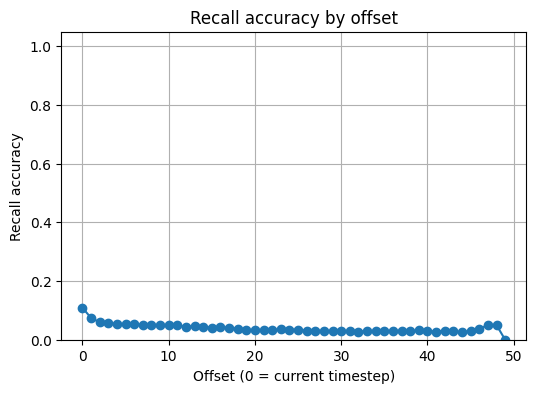

In [9]:
evaluation_config = EvaluationConfig(
    seq_len=training_config.seq_len,
    num_sequences=20,
    key_dim=training_config.key_dim,
    val_dim=training_config.val_dim,
    context_dim=training_config.context_dim,
    output_corr=training_config.output_corr,
)

evaluation_histories = []
for _ in range(evaluation_config.num_sequences):
    dataset = InContextRecallDataset(
        seq_len=evaluation_config.seq_len,
        key_dim=evaluation_config.key_dim,
        val_dim=evaluation_config.val_dim,
        context_size=evaluation_config.context_dim,
        output_corr=evaluation_config.output_corr,
    )
    history = compute_recall_accuracies(
        artifacts.memory_module,
        dataset.inputs,
        dataset.targets,
    )
    evaluation_histories.append(history)

mean_accuracy, counts = average_accuracy_across_sequences(evaluation_histories)
offsets = np.arange(mean_accuracy.shape[0])
mean_accuracy_np = mean_accuracy.detach().cpu().numpy()
counts_np = counts.detach().cpu().numpy()

valid_mask = counts_np > 0
print("--- Recall Accuracy by Offset ---")
for offset, accuracy, count in zip(offsets[valid_mask], mean_accuracy_np[valid_mask], counts_np[valid_mask]):
    print(f"Offset {int(offset)} | Accuracy: {accuracy:.3f} | Observations: {int(count)}")

plt.figure(figsize=(6, 4))
plt.plot(offsets, mean_accuracy_np, marker="o")
plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy by offset")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.show()


--- Average Correct Retrievals per Timestep ---
Timestep 0 | Avg Correct Retrievals: 1.000 | Sequences: 20
Timestep 1 | Avg Correct Retrievals: 1.000 | Sequences: 20
Timestep 2 | Avg Correct Retrievals: 0.900 | Sequences: 20
Timestep 3 | Avg Correct Retrievals: 0.800 | Sequences: 20
Timestep 4 | Avg Correct Retrievals: 0.800 | Sequences: 20
Timestep 5 | Avg Correct Retrievals: 0.950 | Sequences: 20
Timestep 6 | Avg Correct Retrievals: 0.950 | Sequences: 20
Timestep 7 | Avg Correct Retrievals: 0.850 | Sequences: 20
Timestep 8 | Avg Correct Retrievals: 1.000 | Sequences: 20
Timestep 9 | Avg Correct Retrievals: 1.150 | Sequences: 20
Timestep 10 | Avg Correct Retrievals: 1.100 | Sequences: 20
Timestep 11 | Avg Correct Retrievals: 1.150 | Sequences: 20
Timestep 12 | Avg Correct Retrievals: 1.050 | Sequences: 20
Timestep 13 | Avg Correct Retrievals: 1.100 | Sequences: 20
Timestep 14 | Avg Correct Retrievals: 1.250 | Sequences: 20
Timestep 15 | Avg Correct Retrievals: 1.050 | Sequences: 20
Ti

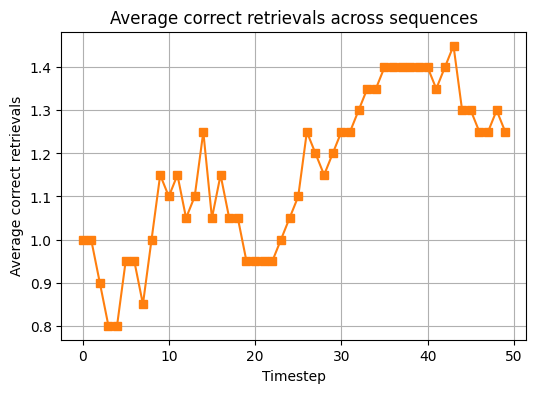

In [10]:
mean_correct_retrievals, contributing_counts = average_correct_retrievals_across_sequences(evaluation_histories)
timesteps = np.arange(mean_correct_retrievals.shape[0])
mean_correct_np = mean_correct_retrievals.detach().cpu().numpy()
contributing_np = contributing_counts.detach().cpu().numpy()

print("--- Average Correct Retrievals per Timestep ---")
for timestep, retrievals, count in zip(timesteps[contributing_np > 0], mean_correct_np[contributing_np > 0], contributing_np[contributing_np > 0]):
    print(f"Timestep {int(timestep)} | Avg Correct Retrievals: {retrievals:.3f} | Sequences: {int(count)}")

plt.figure(figsize=(6, 4))
plt.plot(timesteps, mean_correct_np, marker="s", color="tab:orange")
plt.xlabel("Timestep")
plt.ylabel("Average correct retrievals")
plt.title("Average correct retrievals across sequences")
plt.grid(True)
plt.show()


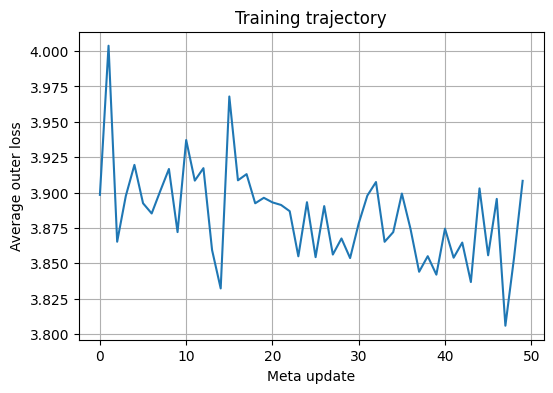

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(artifacts.outer_losses)), artifacts.outer_losses)
plt.xlabel("Meta update")
plt.ylabel("Average outer loss")
plt.title("Training trajectory")
plt.grid(True)
plt.show()
